<a href="https://colab.research.google.com/github/sanyam83/learnopencv/blob/master/Optical%20Character%20Recognition%20using%20PaddleOCR/OCR_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

## Installing dependencies

The folder structure is as follows:

*Root folder*
> *PaddleOCR*

>> *weight files*



> *COCO-text*


>> *COCO-test*

>> *val_words*

>> *gt_test.txt*

>> *val_words_gt.txt*

> *pp-ocrv3_output*

> *pp-ocr_v2_output*

> *nrtr_ouput*

> *srn_output*











> 


In [ ]:
!git clone https://github.com/PaddlePaddle/PaddleOCR.git

In [ ]:
%cd ./PaddleOCR
!pip install -r requirements.txt
!pip install python-Levenshtein
!python -m pip install paddlepaddle-gpu

In [ ]:
# Importing required libraries.
import cv2
import os
import time
import numpy as np
import sys
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img

## Dataset preprocessing

In [ ]:
# Function to display images along with labels.
def disp(pth, gt_annot = '', gt = False, out = False, num = 10):
  img_arr = []
  annot_arr = []
  
  # Appending image array into a list.
  for fimg in sorted((os.listdir(pth))):
    if fimg.endswith('.jpg') or fimg.endswith('.png'):
      demo = img.imread(pth+fimg) 
      img_arr.append(demo)
      
      # Appending dataset output into a list (OCR outputs are stored in different text files for every image).
      if out:
        with open(pth + ''.join(fimg.split())[:-8]+ '.txt') as f:
          out = f.read()
          f.close()
        annot_arr.append(out.lower())
        
      # Appending ground truth annotations into a list (Ground truth of all images are stored in a single text file).
      if gt:
        with open(gt_annot) as f:
          for line in f:
            if line.split(',')[0] == fimg.split('.')[0]: 
              gt = line.split(',')[1].lower()
              annot_arr.append(gt)
              break

      if len(img_arr) == num:
          break

  # Displaying the images along with labels.
  _, axs = plt.subplots(2, 5, figsize=(25, 14))
  axs = axs.flatten()
  for cent, ax,val  in zip(img_arr, axs, annot_arr):
      ax.imshow(cent)
      ax.set_title(val,fontsize=25)
  plt.show()

Creating test set for COCO-text dataset, original dataset can be downloaded from [here](https://rrc.cvc.uab.es/?ch=5). Go to downloads section, register using your email and download the COCO-text dataset using the link under Cropped words dataset section with the name *Cropped word train and validation images and their annotations*. Extract its contents under the folder called COCO-text.

In [ ]:
%cd ../COCO-text/val_words

In [ ]:
# Moving 500 images from val_words to a new folder COCO_test
!shuf -n 500 -e * | xargs -i mv {} ../COCO_test

In [ ]:
# Go through each line of original GT file and check if the image name exist in the extracted test dataset folder and save its label.
%cd ../
with open('./val_words_gt.txt') as f:
  for line in f:
    if os.path.isfile(os.path.join('./COCO_test', line.split(',')[0] + '.jpg')):
      with open('./gt-test.txt', 'a') as new_file:
        new_file.writelines(line)

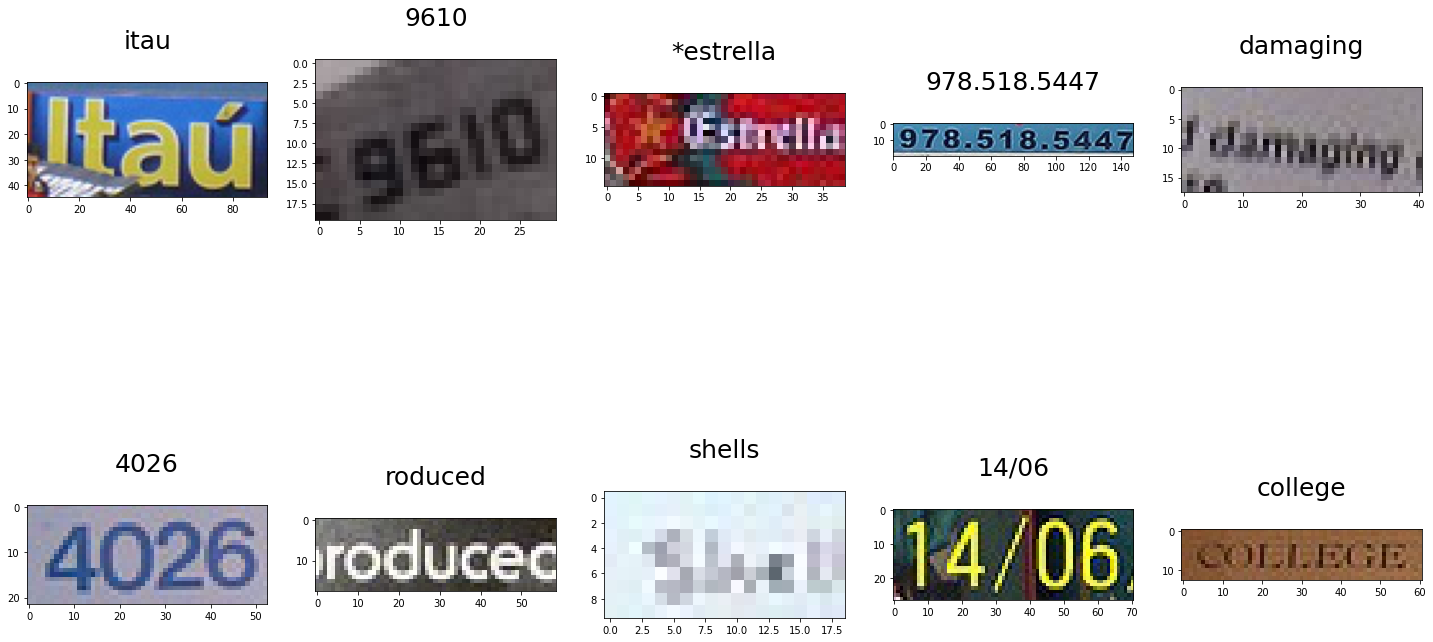

In [ ]:
pth = './COCO_test/'
annot = './gt-test.txt'
disp(pth, annot, gt = True, num = 10)

## Inferencing

In [ ]:
# Importing required methods and functions.
%cd ../PaddleOCR
from tools.infer.predict_rec import *
import tools.infer.utility as utility
from ppocr.postprocess import build_post_process
from ppocr.utils.logging import get_logger
from ppocr.utils.utility import get_image_file_list, check_and_read_gif

### Utility functions

In the following code warmup is done before the actual inferencing. The warmup us done to warm the GPU up when running for the first time as for the first time GPU takes alot of time to run because of the need to intitalize the memory and etc and it helps it to reach its maximum power. Hence the speed is faster for inferencing after the warmup

Inference time will be shown at the end 

In [ ]:
def rec(args, out_path, input, rec_model_dir,rec_image_shape = "3, 32, 320", rec_char_type = "ch", rec_algorithm = "CRNN", show = True, save = True):
    # Assigning values to args as the code is not running from console.
    args.rec_model_dir = rec_model_dir
    args.rec_image_shape = rec_image_shape
    args.rec_char_type = rec_char_type
    args.rec_algorithm = rec_algorithm
    

    # Initializing some helper variables.
    t1 = 0
    t2 = 0
    tot = []
    os.chdir('./PaddleOCR')

    # Passing required values to the args variables.
    if rec_algorithm == "SRN":
      print('yes')
      args.rec_char_dict_path = './ppocr/utils/ic15_dict.txt'
      args.use_space_char = False
    
    if rec_algorithm == 'NRTR':
      args.rec_char_dict_path = './ppocr/utils/EN_symbol_dict.txt'
      args.rec_image_shape = "1,32,100"
    
    # Initializing recognizer.
    image_file_list = get_image_file_list(input)
    text_recognizer = TextRecognizer(args)
    valid_image_file_list = []
    img_list = []

    # Warming up GPU to run it at its full capacity.
    if args.warmup:
        image = np.random.uniform(0, 255, [32, 320, 3]).astype(np.uint8)
        for i in range(10):
            res = text_recognizer([image])

    # Reading and appedding all images' array to a list. 
    for image_file in image_file_list:
        image, flag = check_and_read_gif(image_file)
        if not flag:
            image = cv2.imread(image_file)
        if image is None:
            logger.info("error in loading image:{}".format(image_file))
            continue
        valid_image_file_list.append(image_file)
        img_list.append(image)

    # Applying OCR to the images.
    t1 = time.time()
    try:
        rec_res, _ = text_recognizer(img_list)
    except Exception as E:
        logger.info(traceback.format_exc())
        logger.info(E)
        exit()
    
    # Calculating FPS and printing the info.
    t2 = time.time()
    fps = str(t2-t1)
    for ino in range(len(img_list)):
        logger.info("Predicts of {}:{}".format(valid_image_file_list[ino],
                                              rec_res[ino]))
        if save:
          cv2.imwrite(os.path.join(out_path,valid_image_file_list[ino].split('/')[-1].split('.')[0] + '_rec' + '.jpg'),img_list[ino])
          with open(os.path.join(out_path,valid_image_file_list[ino].split('/')[-1].split('.')[0] + '.txt'), 'w') as f:
            f.write(str(rec_res[ino]))
    logger.info("Time taken recognize all images : {}".format(fps))
    print(len(image_file_list))
    logger.info("Average fps : {}".format(1/(float(fps)/len(image_file_list))))
    
    #cv2.putText(image, str(rec_res[ino]),(0, int(15 * 1)), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), thickness=1)
    
    # Displaying and saving of the output according to the parameters set.
    if show:
      plt.figure(figsize = (25,14))
      plt.imshow(image)
      plt.show()

calculating levenshtein distance i.e. changes required to acheive the desired text

The less the score the better

In [ ]:
def score_calc(pth, annot):
  # Importing distance metric.
  from Levenshtein import distance
  score_all = []

  # Looping through the output text files and storing the OCR output in a variable.
  for out_file in os.listdir(pth):
    if out_file.endswith('.txt'):
      with open(os.path.join(pth, out_file), 'rb') as f:
        out = f.read()
        f.close()
      
      # Cleaning the OCR output text.
      try:
        out = str(out).split(',')[1].split(',')[0].replace("'", '').lower()
      except:
        print('OCR output does not exist')

      # Opening the ground truth file and calculating distance between ground truth and OCR output. 
      with open(annot) as f:
        for line in f:
          #print(out_file.split('.')[0], line.split(',')[0])
          if line.split(',')[0] == out_file.split('.')[0]: 
            gt = line.split(',')[1].lower()
            score = distance(str(out), str(gt))/len(gt)
            score_all.append(score)
            break
  # Printing the average score.
  print("final score:", sum(score_all)/len(score_all))

### PaddlePadddle-OCRv3 (PP-OCRv3)

In [ ]:
# Downloading and extracting weights into PaddleOCR folder.
!wget https://paddleocr.bj.bcebos.com/PP-OCRv3/chinese/ch_PP-OCRv3_rec_infer.tar
!tar xf ch_PP-OCRv3_rec_infer.tar

In [ ]:
# Running the OCR and storing the output in a folder specified under out_path in the root directory.
%cd ../
out_path = '../pp-ocrv3_output'
rec_model_dir = './ch_PP-OCRv3_rec_infer'
input = '../COCO-text/COCO_test'
sys.argv = ['']
rec(utility.parse_args(), out_path, input, rec_model_dir, show = False)

/content/drive/MyDrive/root_paddle_comparsion


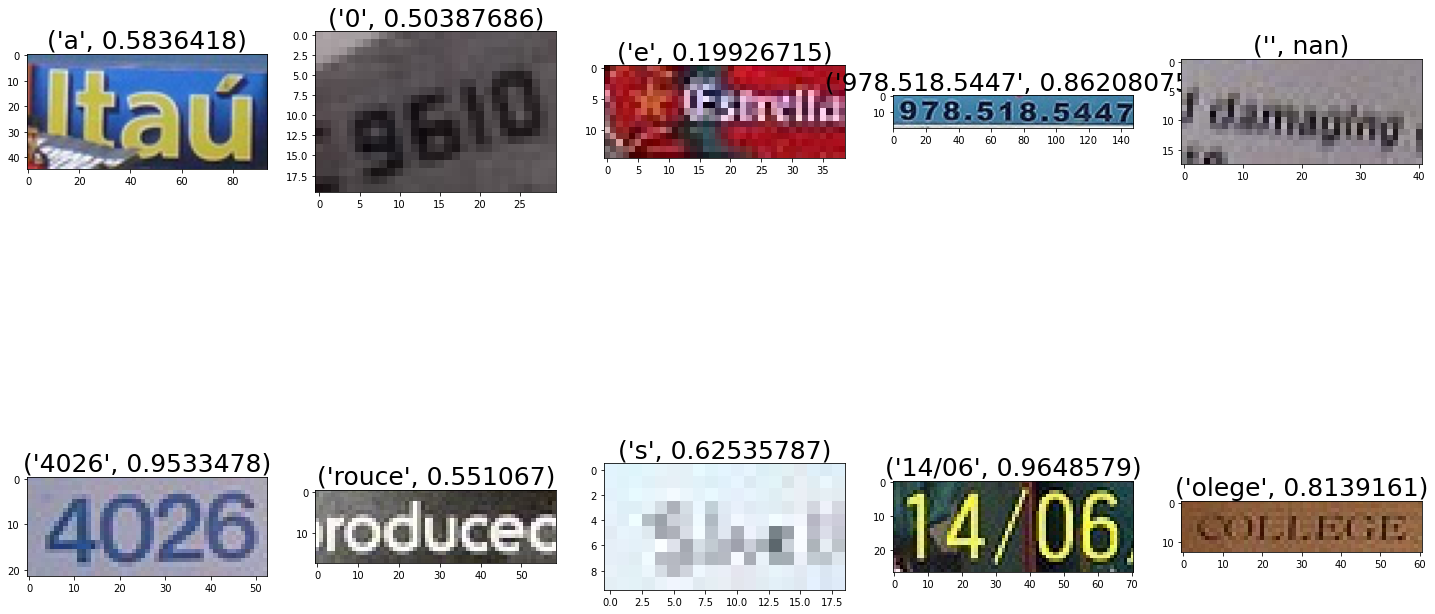

In [ ]:
%cd ../
pth = './pp-ocrv3_output/'
disp(pth, out = True, num = 10) 

In [ ]:
result_path = './pp-ocrv3_output'
gt = './COCO-text/gt-test.txt'
score_calc(result_path, gt)

/content/drive/MyDrive/root_paddle_comparsion
final score: 1.5627663355163364


### PaddlePaddle-OCRv2 (PP-OCRv2)

In [ ]:
# Downloading and extracting weights.
%cd ./PaddleOCR
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.1/chinese/ch_PP-OCRv2_rec_infer.tar
!tar xf ch_PP-OCRv2_rec_infer.tar

In [ ]:
# Running the OCR and storing the output in a folder specified under out_path in the root directory.
%cd ../
out_path = '../pp-ocrv2_output'
rec_model_dir = './ch_PP-OCRv2_rec_infer'
input = '../COCO-text/COCO_test'
sys.argv = ['']
rec(utility.parse_args(), out_path, input, rec_model_dir, show = False)

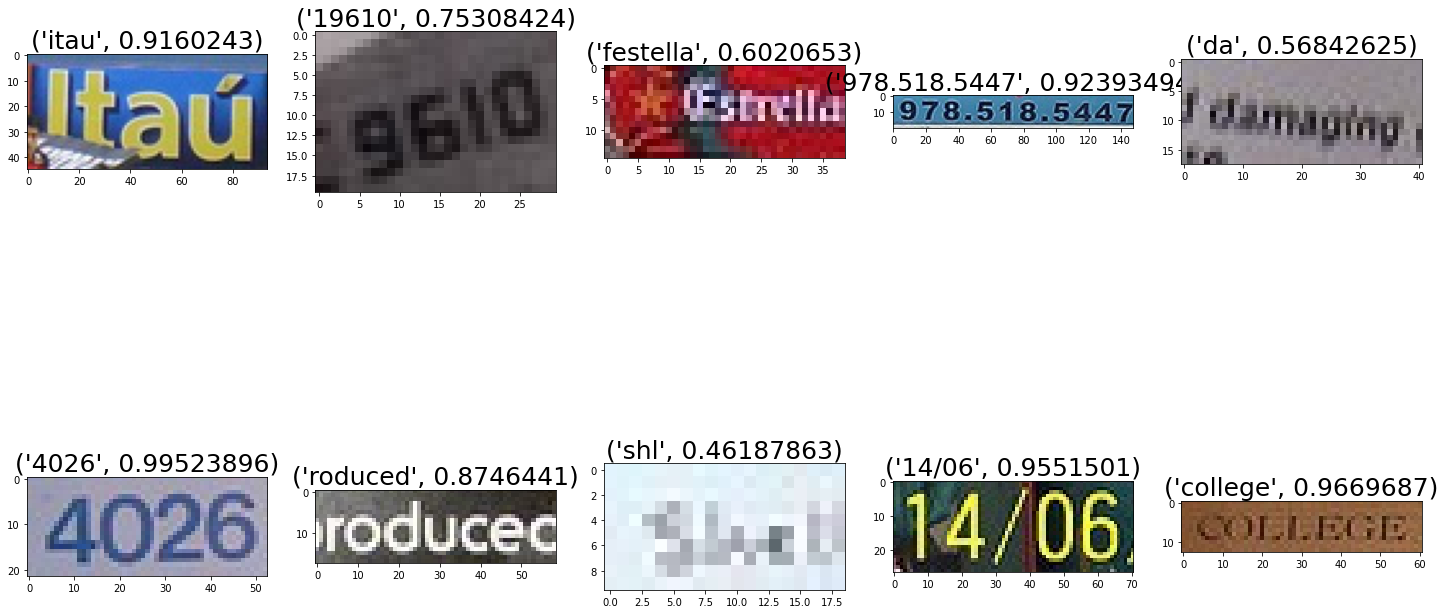

In [ ]:
# Displaying outputs.
%cd ../
pth = './pp-ocrv2_output/'
disp(pth, out = True, num = 10) 

In [ ]:
# Calculating score.
result_path = './pp-ocrv2_output'
gt = './COCO-text/gt-test.txt'
score_calc(result_path, gt)

final score: 1.8384214137714139


### SRN

In [ ]:
# Downloading and extracting weights.
%cd ./PaddleOCR
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/en/rec_r50_vd_srn_train.tar
!tar xf rec_r50_vd_srn_train.tar

# Converting trained model to inference model.
!python tools/export_model.py -c configs/rec/rec_r50_fpn_srn.yml -o Global.pretrained_model=./rec_r50_vd_srn_train/best_accuracy  Global.save_inference_dir=./inference/srn


In [ ]:
# Running the OCR and storing the output in a folder specified under out_path in the root directory.
%cd ../
out_path = '../srn_output'
image_dir = '../COCO-text/COCO_test'
rec_model_dir = './inference/srn'
sys.argv = ['']
rec(utility.parse_args(), out_path, image_dir, rec_model_dir, rec_image_shape = '1, 64, 256', rec_char_type = 'en',rec_algorithm = 'SRN', show = False)

/content/gdrive/MyDrive/root_paddle_comparsion


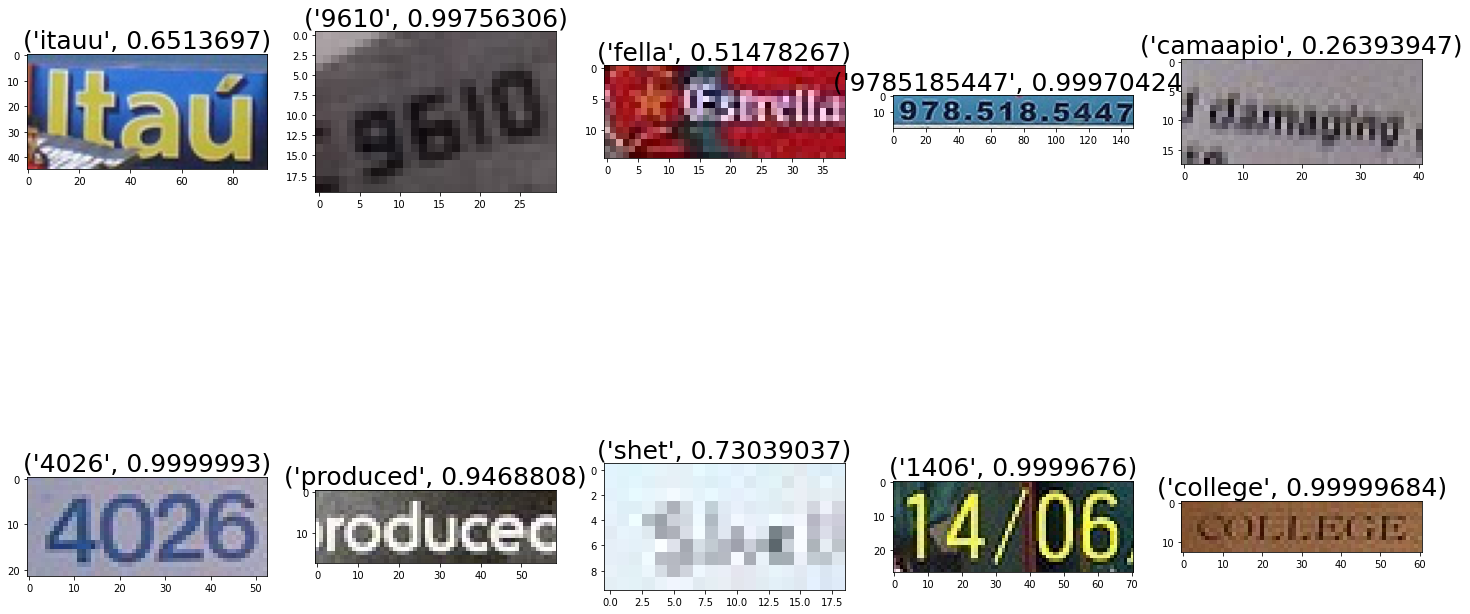

In [ ]:
# Displaying outputs.
%cd ../
pth = './srn_output/'
disp(pth, out = True, num = 10)

In [ ]:
# Calculating score.
result_path = './srn_output'
gt = './COCO-text/gt-test.txt'
score_calc(result_path, gt)

final score: 1.8308108299108317


### NRTR

In [ ]:
# Downloading, extracting and converting training model into inference model .
%cd ./PaddleOCR
!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/en/rec_mtb_nrtr_train.tar
!tar xf rec_mtb_nrtr_train.tar
!python tools/export_model.py -c configs/rec/rec_mtb_nrtr.yml -o Global.pretrained_model=./rec_mtb_nrtr_train/best_accuracy  Global.save_inference_dir=./inference/nrtr

In [ ]:
# Running the OCR and storing the output in a folder specified under out_path in the root directory.
%cd ../
out_path = '../nrtr_output'
image_dir = '../COCO-text/COCO_test'
rec_model_dir = './inference/nrtr'
sys.argv = ['']
rec(utility.parse_args(), out_path, image_dir, rec_model_dir, rec_char_type = 'en', rec_image_shape = "1,32,100", rec_algorithm = 'NRTR', show = False)

/content/gdrive/.shortcut-targets-by-id/1a7WqcAkF3t7zzMvRsdVBpo3kg9Sxei9l/root_paddle_comparsion


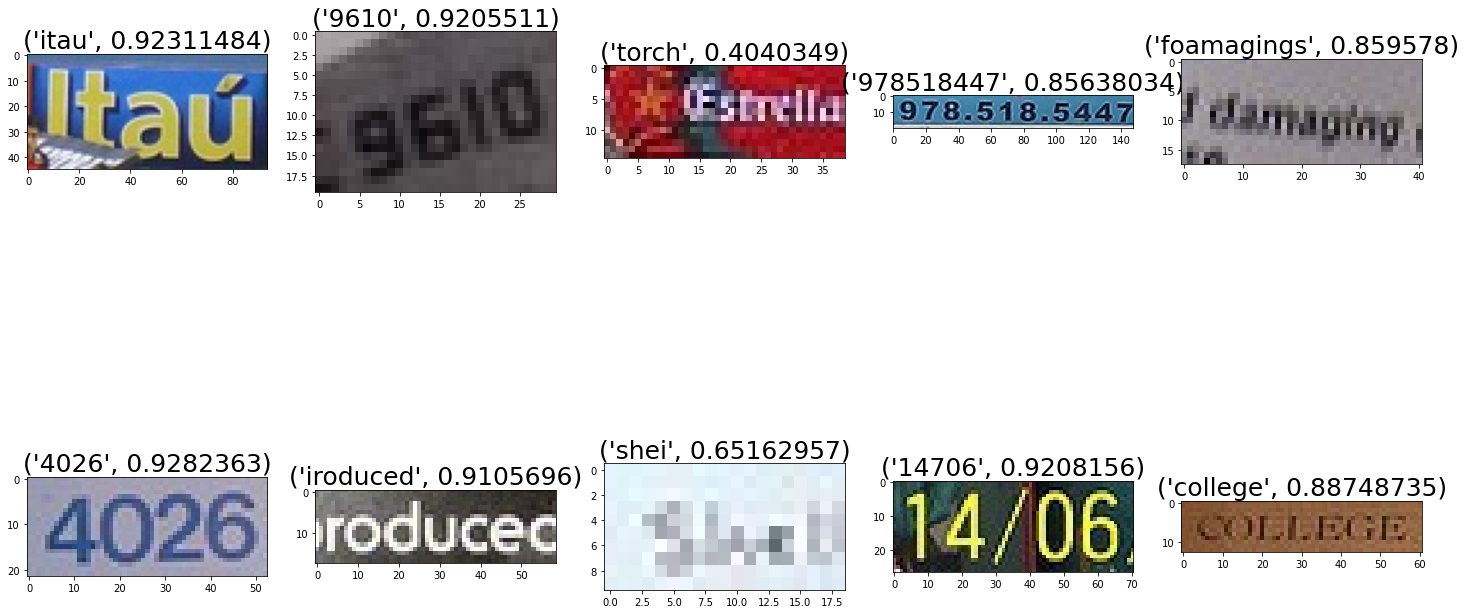

In [ ]:
# Displaying outputs.
%cd ../
pth = './nrtr_output/'
disp(pth, out = True, num = 10)

In [ ]:
# Calculating score.
result_path = './nrtr_output'
gt = './COCO-text/gt-test.txt'
score_calc(result_path, gt)

final score: 1.5954822954822954
